## Brief Introduction ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business. </p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

</p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

Well, [Recruit Holdings](http://recruit-holdings.com/who/value/) has unique access to key datasets that could make automated future customer prediction possible. Specifically, <b>Recruit Holdings</b> owns <b>Hot Pepper Gourmet </b>(a restaurant review service), <b>AirREGI</b> (a restaurant point of sales service), and <b>Restaurant Board</b> (reservation log management software).

</p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

In this project, we would be using the reservation and visitation data (from the above mentioned sources) to predict the total number of visitors to a restaurant for future dates. This information will help restaurants to be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

</p>

## Importing Necessary Libraries 

In [1]:
# Importing Numpy & Pandas Libraries
import numpy as np
import pandas as pd 

# For Linear Regression (Decision Tree Regressor, Linear Regression) 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Test-train split Libraries
from sklearn.model_selection import train_test_split

# Libraries for Root-Mean-Square-Error Detection
from sklearn.metrics import mean_squared_error
from math import sqrt

# For plotting graph (Correlation matrix & Heatmap)
import seaborn as sns
import matplotlib.pyplot as plt

# For Multiple Regression (KNeighborsRegressor , Ridge Regression, Logistic Regression)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

## Data Description ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

For this project, we have a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites: <br></p>
<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
i. <b>Hot Pepper Gourmet (hpg)</b>: Similar to <b>Yelp</b>, here users can search restaurants and also make a reservation online <br>
ii. <b>AirREGI / Restaurant Board (air)</b>: Similar to <b>Square</b>, a reservation control and cash register system<br>

</p>

## Research Objective ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

We have to use the reservations, visits, and other information from these sites to <i> forecast future restaurant visitor totals on a given date.</i> The training data covers the dates from <i>2016 until April 2017</i>. </p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. <i>The test set intentionally spans a holiday week in Japan called the <b>"Golden Week."</b></i>
</p>
<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.
</p>

## Data Limitations/Restrictions ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

i. There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed. <br><br>
ii. Not all restaurants are covered by both systems, and that the data which has been provided is beyond the restaurants for which we must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.
</p>

## Data File Description ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique <i>air_store_id</i> and <i>hpg_store_id</i>. 
</p>

### File 1 - air_reserve.csv ###

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

This file contains reservations made in the air system. The <i>reserve_datetime</i> indicates the time when the reservation was created, whereas the <i>visit_datetime</i> is the time in the future where the visit will occur. It has the following attributes:<br><br>

i.   <b>air_store_id </b> - the restaurant's id in the air system <br>
ii.  <b>visit_datetime</b> - the time of the reservation <br>
iii. <b>reserve_datetime</b> - the time the reservation was made <br>
iv.  <b>reserve_visitors</b> - the number of visitors for that reservation <br>

</p>

** Getting the glimpse of air_reserve.csv file **

In [2]:
air_reserve = pd.read_csv('../input/air_reserve.csv')
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


** Checking for the number of rows and columns **

In [3]:
print('air_reserve.csv has', air_reserve.shape[0], 'rows and' , air_reserve.shape[1] , 'columns.')

air_reserve.csv has 92378 rows and 4 columns.


** Checking for the NULL values **

In [4]:
air_reserve.isnull().any()

air_store_id        False
visit_datetime      False
reserve_datetime    False
reserve_visitors    False
dtype: bool

This shows that the <b> air_reserve </b> dataset does not contain any <b> NULL </b> values.

### File 2 - hpg_reserve.csv ###

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

This file contains reservations made in the hpg system. It has the following attributes:<br><br>

i. <b>hpg_store_id </b>- the restaurant's id in the hpg system<br>
ii. <b>visit_datetime</b> - the time of the reservation<br>
iii. <b>reserve_datetime</b> - the time the reservation was made<br>
iv. <b>reserve_visitors</b> - the number of visitors for that reservation<br>
</p>

** Getting the glimpse of hpg_reserve.csv file **

In [5]:
hpg_reserve = pd.read_csv('../input/hpg_reserve.csv')
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


** Checking for the number of rows and columns **

In [6]:
print('hpg_reserve.csv has', hpg_reserve.shape[0], 'rows and' , hpg_reserve.shape[1] , 'columns.')

hpg_reserve.csv has 2000320 rows and 4 columns.


** Checking for the NULL values **

In [7]:
hpg_reserve.isnull().any()

hpg_store_id        False
visit_datetime      False
reserve_datetime    False
reserve_visitors    False
dtype: bool

This shows that the <b> hpg_reserve </b> dataset does not contain any <b> NULL </b> values.

### File 3 - air_store_info.csv ###

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

This file contains information about select air restaurants. Column names and contents are self-explanatory.<br>

</p>
<p>

i. <b>air_store_id</b><br>
ii. <b>air_genre_name</b><br>
iii. <b>air_area_name</b><br>
iv. <b>latitude</b><br>
v. <b>longitude</b><br>

</p>

** Getting the glimpse of air_store_info.csv file **

In [8]:
air_store_info = pd.read_csv('../input/air_store_info.csv')
air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


** Checking for the number of rows and columns **

In [9]:
print('air_store_info.csv has', air_store_info.shape[0], 'rows and' , air_store_info.shape[1] , 'columns.')

air_store_info.csv has 829 rows and 5 columns.


** Checking for the NULL values **

In [10]:
air_store_info.isnull().any()

air_store_id      False
air_genre_name    False
air_area_name     False
latitude          False
longitude         False
dtype: bool

This shows that the <b> air_store_info </b> dataset does not contain any <b> NULL </b> values.

### File 4 - hpg_store_info.csv ###

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.<br>

</p>
<p>

i. <b>hpg_store_id</b><br>
ii. <b>hpg_genre_name</b><br>
iii. <b>hpg_area_name</b><br>
iv. <b>latitude</b><br>
v. <b>longitude</b><br>

</p>

** Getting the glimpse of hpg_store_info.csv file **

In [11]:
hpg_store_info = pd.read_csv('../input/hpg_store_info.csv')
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


** Checking for the number of rows and columns **

In [12]:
print('hpg_store_info.csv has', hpg_store_info.shape[0], 'rows and' , hpg_store_info.shape[1] , 'columns.')

hpg_store_info.csv has 4690 rows and 5 columns.


** Checking for the NULL values **

In [13]:
hpg_store_info.isnull().any()

hpg_store_id      False
hpg_genre_name    False
hpg_area_name     False
latitude          False
longitude         False
dtype: bool

This shows that the <b> hpg_store_info </b> dataset does not contain any <b> NULL </b> values.

### File 5 - store_id_relation.csv ###

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
This file allows to join select restaurants that have both the air and hpg system.<br><br>

i. <b>hpg_store_id</b><br>
ii. <b>air_store_id</b><br>
</p>

** Getting the glimpse of store_id_relation.csv file **

In [14]:
store_id_relation = pd.read_csv('../input/store_id_relation.csv')
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


** File 6 - air_visit_data.csv **

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
This file contains historical visit data for the air restaurants. <br><br>

i. <b>air_store_id</b><br>
ii. <b>visit_date</b> - the date<br>
iii. <b>visitors</b> - the number of visitors to the restaurant on the date<br>
</p>

** Getting the glimpse of air_visit_data.csv file **

In [15]:
air_visit_data = pd.read_csv('../input/air_visit_data.csv')
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


** File 7 - date_info.csv **

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
This file gives basic information about the calendar dates in the dataset. <br><br>

i. <b>calendar_date</b><br>
ii. <b>day_of_week</b><br>
iii. <b>holiday_flg </b>- is the day a holiday in Japan<br>
</p>

** Getting the glimpse of date_info.csv file **

In [16]:
date_info = pd.read_csv('../input/date_info.csv')
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### Joining the Datasets ###

In [17]:
air = pd.merge(air_reserve,air_store_info,on='air_store_id')
hpg = pd.merge(hpg_reserve,hpg_store_info,on='hpg_store_id')

** Getting the glimpse of the data **

In [18]:
air.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [19]:
hpg.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
3,hpg_dac72789163a3f47,2016-01-06 12:00:00,2016-01-06 08:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
4,hpg_dac72789163a3f47,2016-01-10 17:00:00,2016-01-04 22:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


In [20]:
airrel = pd.merge(air,store_id_relation,how='left',on='air_store_id')
hpgrel = pd.merge(hpg,store_id_relation,how='left',on='hpg_store_id')
full = pd.merge(airrel,hpgrel,how='outer')
print("There are ",len(air_reserve)," restaurants with AIR & ",len(hpg_reserve)," with HPG. But",len(store_id_relation),'restaurants are common.')

There are  92378  restaurants with AIR &  2000320  with HPG. But 150 restaurants are common.


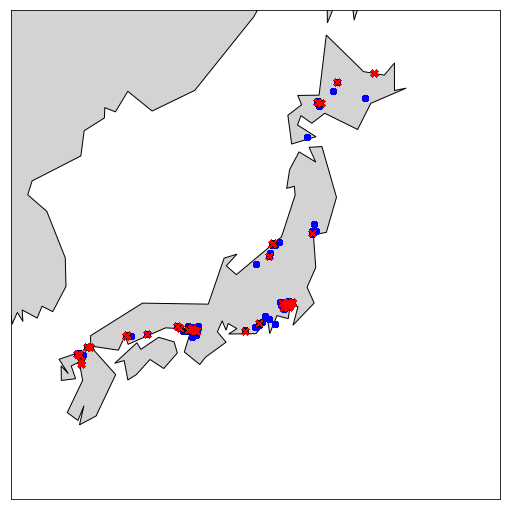

In [21]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1,figsize=(15,9))
m = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)

m.drawcoastlines()
m.fillcontinents(color='lightgrey',lake_color='aqua',zorder=1)
m.scatter(hpg.longitude.values,hpg.latitude.values,marker='o',color='blue',zorder=999,latlon=True)
m.scatter(air.longitude.values,air.latitude.values,marker='x',color='red',zorder=999,latlon=True)
#ax.legend()
plt.show()

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
The above map of Japan shows the <b> AIR </b> restaurants in 'red cross marks' and the <b> HPG </b> restaurants in 'blue dots'. From this, we can make a fair idea about the location of the two kinds of restaurants.
</p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
Now, let's try to relate the identified groups with the biggest cities:

* **Cluster 0** refers to **Tokyo** <br>
* **Cluster 1** refers to **Osaka** <br>
* **Cluster 2** refers to **Sapporo** <br>
* **Cluster 3** refers to **Fukuoka** <br>
* **Cluster 4** refers to **Nigata** <br>
* **Cluster 5** referst to **Hiroshima** <br>
* **Cluster 6** refers to **Shizouku** <br>
* **Cluster 7** refers to **Sendai** <br>
* **Cluster 9** refers to **Kobe** <br>
<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

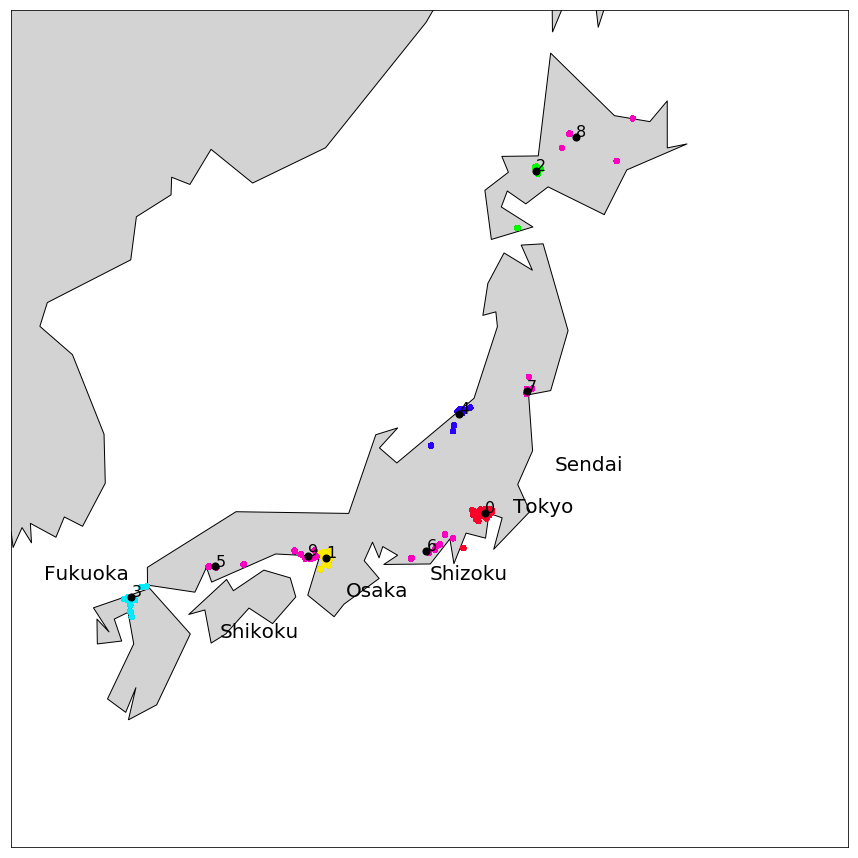

In [23]:
cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in full['cluster']]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)





plt.annotate('Tokyo', xy=(0.60, 0.4), xycoords='axes fraction',fontsize=20)
plt.annotate('Osaka', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)

plt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)


plt.annotate('Shizoku', xy=(0.50, 0.32), xycoords='axes fraction',fontsize=20)

plt.annotate('Sendai', xy=(0.65, 0.45), xycoords='axes fraction',fontsize=20)

plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)

for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
plt.show()

### Bar Charts ###

The chart below shows visitor distribution vs. varoius locations in Japan. The cluster number represents the places tagged with the cluster number in the above pictorial map of Japan.

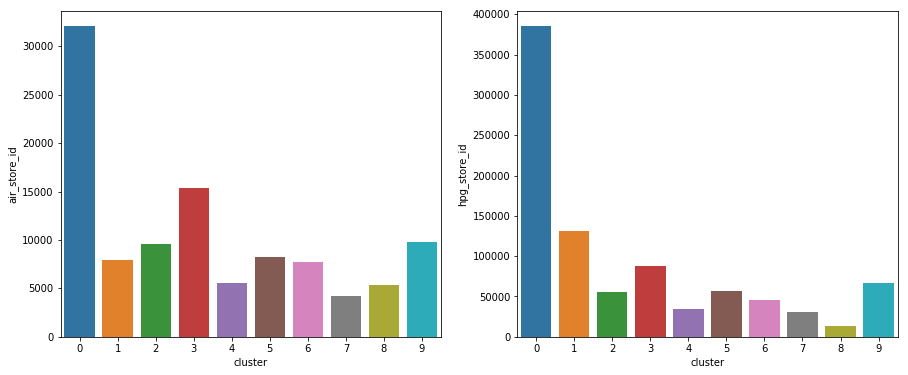

In [24]:
f,axa = plt.subplots(1,2,figsize=(15,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust.cluster,y=hist_clust.air_store_id,ax=axa[0])

sns.barplot(x=hist_clust.cluster,y=hist_clust.hpg_store_id,ax=axa[1])

plt.show()

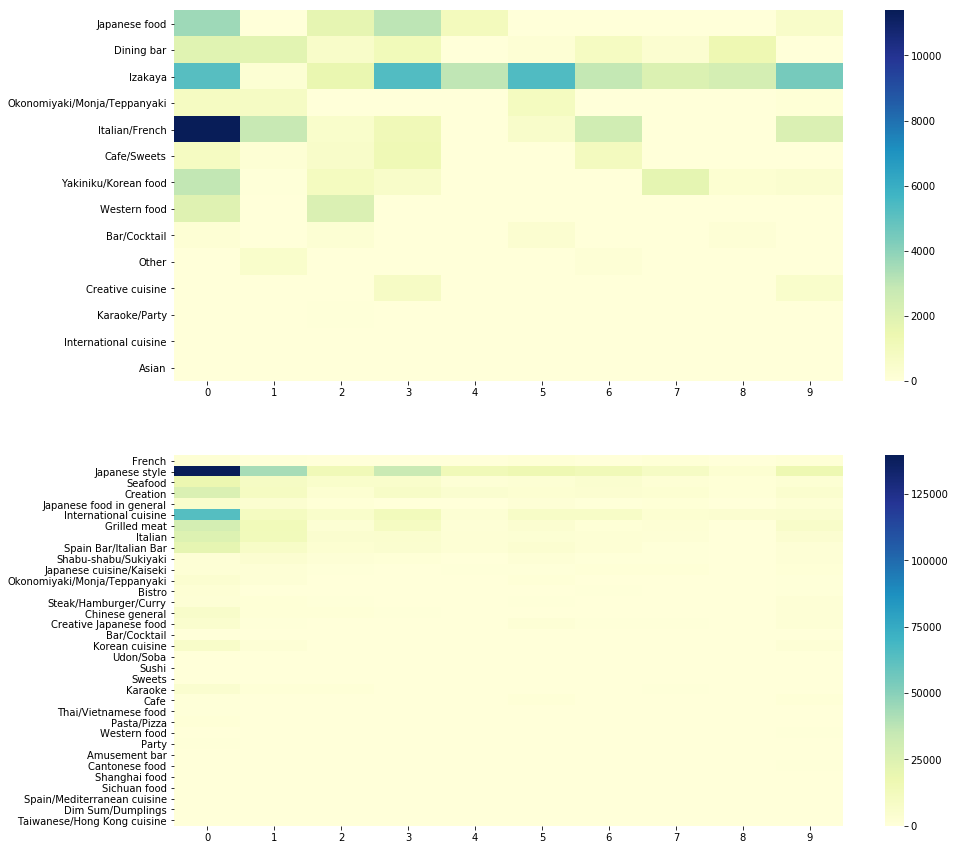

In [25]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster','air_genre_name'],as_index=False).count()
hpg_genre = full.loc[full.hpg_genre_name.isnull()==False].groupby(['cluster','hpg_genre_name'],as_index=False).count()

genres = air.air_genre_name.unique()

#i = 0
f,axa= plt.subplots(2,1,figsize=(15,15))
hm = []
for i in range(10):
    genres_count = [ air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]['air_store_id'].values[0] if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=axa[0])

genres = hpg.hpg_genre_name.unique()
hm = []
for i in range(10):
    genres_count = [ hpg_genre.loc[hpg_genre.cluster==i].loc[hpg_genre.hpg_genre_name==name]['hpg_store_id'].values[0] if name in hpg_genre.loc[hpg_genre.cluster==i].hpg_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=axa[1])


plt.show()

## Japanese Holidays ##

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
Japanese holidays excluding Saturday and Sunday.
</p>

In [26]:
date_info.loc[date_info.holiday_flg==1].loc[(date_info.day_of_week !='Saturday')].loc[date_info.day_of_week !='Sunday']

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1
125,2016-05-05,Thursday,1
199,2016-07-18,Monday,1
223,2016-08-11,Thursday,1


In [27]:
vdt = pd.to_datetime(full.visit_datetime)
rdt = pd.to_datetime(full.reserve_datetime)
full['vd']=vdt.dt.date
full['vt']=vdt.dt.time
full['rd']=rdt.dt.date
full['rt']=rdt.dt.time

nf = pd.merge(full,date_info[['calendar_date','holiday_flg']],left_on='vd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf = pd.merge(nf,date_info[['calendar_date','holiday_flg']],left_on='rd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'reservation_holiday'})
nf = nf.drop(['calendar_date'],axis=1)
nf.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster,vd,vt,rd,rt,visit_holiday,reservation_holiday


In [28]:
deltatime = vdt - rdt
days = deltatime.dt.days

days.describe()

count    963686.000000
mean          6.909061
std          11.507296
min           0.000000
25%           1.000000
50%           4.000000
75%           9.000000
max         393.000000
dtype: float64

ugiuguogg

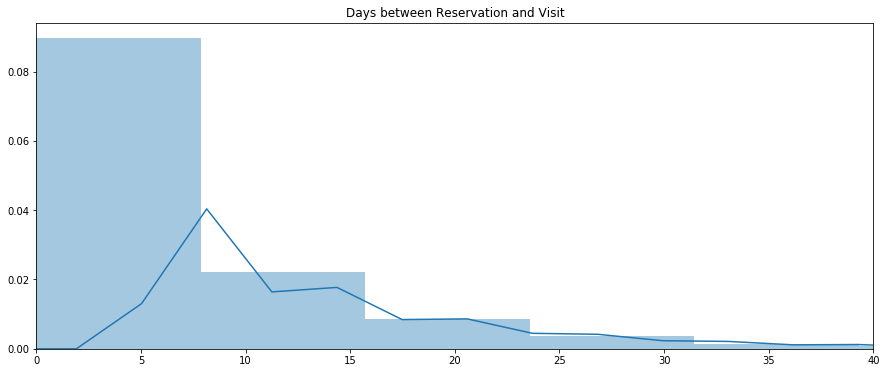

In [29]:
f,axa = plt.subplots(1,1,figsize=(15,6))
sns.distplot(days)
plt.xlim(0,40)
axa.set_title('Days between Reservation and Visit')
plt.show()

7rfyigpuhpoi

In [30]:
dts = pd.to_datetime(date_info.calendar_date)
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date
date_info['dy'] = dts.dt.dayofyear
date_info['dw'] = [days.index(dw) for dw in date_info.day_of_week]
date_info.head()

,calendar_date,day_of_week,holiday_flg,dy,dw
0,2016-01-01,Friday,1,1,5
1,2016-01-02,Saturday,1,2,6
2,2016-01-03,Sunday,1,3,0
3,2016-01-04,Monday,0,4,1
4,2016-01-05,Tuesday,0,5,2


In [31]:
nf = pd.merge(full,date_info[['calendar_date','holiday_flg']],left_on='vd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf = pd.merge(nf,date_info[['calendar_date','holiday_flg']],left_on='rd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'reservation_holiday'})
nf = nf.drop(['calendar_date'],axis=1)
nf.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster,vd,vt,rd,rt,visit_holiday,reservation_holiday
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2016-01-01,19:00:00,2016-01-01,16:00:00,1,1
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2016-01-01,20:00:00,2016-01-01,16:00:00,1,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,hpg_bcecaa70222d94e5,NaN,NaN,1,2016-01-01,19:00:00,2016-01-01,19:00:00,1,1
3,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,hpg_bcecaa70222d94e5,NaN,NaN,1,2016-01-01,19:00:00,2016-01-01,19:00:00,1,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,hpg_878cc70b1abc76f7,NaN,NaN,8,2016-01-01,20:00:00,2016-01-01,01:00:00,1,1


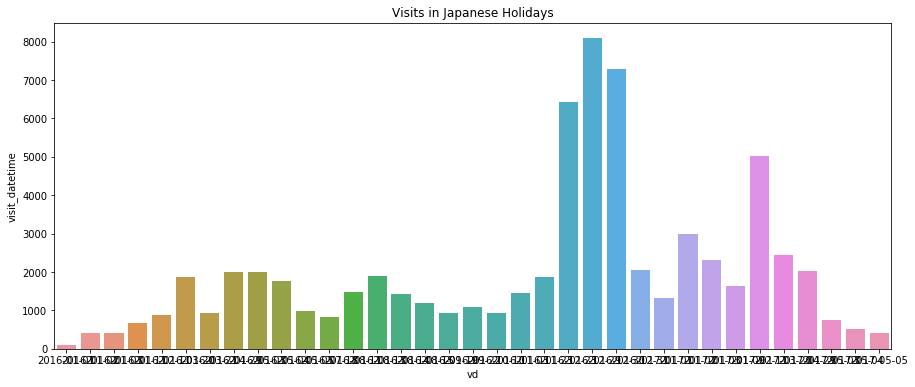

In [32]:
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==1].groupby(['vd'],as_index=False).count()
sns.barplot(x = vholidayhist.vd,y=vholidayhist.visit_datetime)
ax.set_title('Visits in Japanese Holidays')
plt.show()

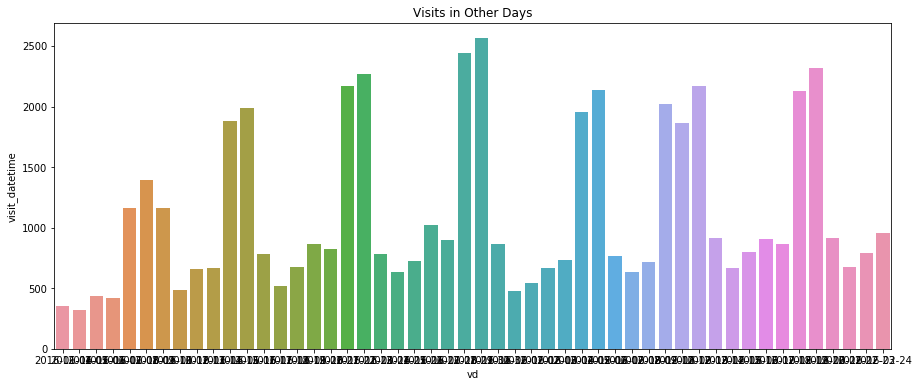

In [33]:
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==0].groupby(['vd'],as_index=False).count()
sns.barplot(x = vholidayhist.vd[0:50],y=vholidayhist.visit_datetime)
ax.set_title('Visits in Other Days')
plt.show()

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
The above charts shows the number of visitors' trend in Japanese holidays and in other days.
</p>

<p style="font-family: Arial; font-size:1.0em;color:black; font-style:bold">
Now, by using the reservation and visitation data (from the above mentioned sources) we would be predicting the total number of visitors to a restaurant for future dates and generating the data for the same.  This information will help restaurants to be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers. 
</p>

In [34]:
import glob, re
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [35]:
data = {
    'tra': pd.read_csv('../input/air_visit_data.csv'),
    'as': pd.read_csv('../input/air_store_info.csv'),
    'hs': pd.read_csv('../input/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/air_reserve.csv'),
    'hr': pd.read_csv('../input/hpg_reserve.csv'),
    'id': pd.read_csv('../input/store_id_relation.csv'),
    'tes': pd.read_csv('../input/sample_submission.csv'),
    'hol': pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }


In [36]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [37]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [38]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [39]:
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [40]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [41]:
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

In [42]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

In [43]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2


train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']


train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5
    
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)

In [ ]:


model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
model3.fit(train[col], np.log1p(train['visitors'].values))

preds1 = model1.predict(train[col])
preds2 = model2.predict(train[col])
preds3 = model3.predict(train[col])

print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])

test['visitors'] = 0.3*preds1+0.3*preds2+0.4*preds3
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
del train; del data;


dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../input/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = 0.7*sub_merge['visitors_x'] + 0.3*sub_merge['visitors_y']* 1.1
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)
